In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from ordercompute import orderCompute

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt

In [2]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s %s, %s' % (dt.isoformat(), self.msP.time, txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        self.fromdate = datetime.datetime(2016, 3, 2)
        # To keep track of pending orders
        self.order = None
        
        self.isImported = False
        self.x = -1
        self.target = -1
        
        class mshiftParams():
            pass
        self.msP = mshiftParams()
        self.msP.time = self.data.datetime.time(0).isoformat()
        self.msP.date = str(self.fromdate).split(' ')[0]
        self.msP.symbol = 'EURUSD'
        self.msP.quantile = 0.15
        self.msP.n_samples = 500

        self.srlevels = orderCompute(self.msP).newSR()

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.4f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.4f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def next(self):
        self.msP.time = self.data.datetime.time().isoformat()
        self.msP.date = self.data.datetime.date().isoformat()
        
        if self.data.datetime.time() < datetime.time(0, 10) and self.isImported == False:
            self.srlevels = orderCompute(self.msP).newSR()
            self.isImported = True
        if self.data.datetime.time() == datetime.time(0, 11):
            self.isImported = False
            
        # Log the closing price of the series from the reference
        self.log('Close, %f.4' % self.dataclose[0])

        # Check if an order is pending
        if self.order:
            return
        #skip = None
        
            '''
            if x == -1 or x-1 < len(self.srlevels):
                skip = True
            else:
                skip = False
            '''

        # Get last relevant level touch point
        #
        
        #
        # Check if we are in the market
        if not self.position and self.x != len(self.srlevels)-1: #and skip == False:
            if self.dataclose[-1] > self.srlevels[self.x] and self.dataclose[0] <= self.srlevels[self.x]:
                self.log('BUY CREATE, %.4f' % self.dataclose[0])
                self.order = self.buy()
                self.target = self.srlevels[self.x-1]
                self.stop = self.srlevels[self.x+1]
            elif self.dataclose[-1] < self.srlevels[self.x] and self.dataclose[0] >= self.srlevels[self.x]:
                pass
        else:
            if self.dataclose[0] > self.target or self.dataclose[0] < self.stop: #or self.dataclose[0] <= self.srlevels[x-1]:
                self.log('POSITION CLOSE, %.4f' % self.dataclose[0])
                self.order = self.close()
                
        if int(str(self.msP.time).split(':')[1]) % 2 == 0:
            self.x = -1
            for i in range(int(len(self.srlevels))-1):
                if self.srlevels[i+1] < self.dataclose[0] < self.srlevels[i]:
                    self.x = i
                    break

Starting Portfolio Value: 100000.0000
2016-03-02
2016-03-01

S/R-levels already saved at ml_strat/clustering_return/ml_results_EURUSD_2016_03_01_0.15_500.csv
Importing...

-------------------------
	S/R-levels
-------------------------
1.0834
1.0856
1.0872
1.0879
1.0894


2016-03-07
2016-03-06

S/R-levels already saved at ml_strat/clustering_return/ml_results_EURUSD_2016_03_06_0.15_500.csv
Importing...

-------------------------
	S/R-levels
-------------------------
1.0989
1.0991
1.0992
1.0994
1.0995
1.0996
1.0998


2016-03-07 00:00:00, Close, 1.099490.4
2016-03-07 00:00:00, BUY CREATE, 1.0995
2016-03-07 00:00:00, BUY EXECUTED, 1.0995
2016-03-07 00:01:00, Close, 1.099520.4
2016-03-07 00:01:00, POSITION CLOSE, 1.0995
2016-03-07 00:01:00, SELL EXECUTED, 1.0995
2016-03-07 00:02:00, Close, 1.099610.4
2016-03-07 00:03:00, Close, 1.099590.4
2016-03-07 00:04:00, Close, 1.099570.4
2016-03-07 00:05:00, Close, 1.099580.4
2016-03-07 00:06:00, Close, 1.099560.4
2016-03-07 00:07:00, Close, 1.099650

<IPython.core.display.Javascript object>


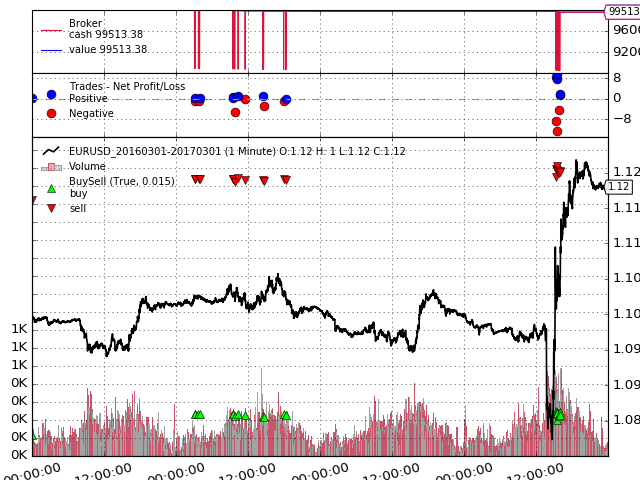

Final Portfolio Value: 99513.3819


In [3]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()

    cerebro.addstrategy(TestStrategy)

    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    #datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')
    datapath = 'data/tickdump/EURUSD_20160301-20170301.csv' #YHOO1617.csv'
    # Create a Data Feed
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2016, 3, 7),
        todate=datetime.datetime(2016, 3, 11),
        timeframe=bt.TimeFrame.Minutes,
        dtformat='%d.%m.%Y %H:%M:%S.000')

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.4f' % cerebro.broker.getvalue())
    
    cerebro.addsizer(bt.sizers.FixedSize, stake=10000)
    cerebro.broker.setcommission(commission=0.001)
    
    # Run over everything
    cerebro.run()
    cerebro.plot()

    # Print out the final result
    print('Final Portfolio Value: %.4f' % cerebro.broker.getvalue())